# 0.0. IMPORTS

In [2]:
import pandas as pd
import math
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
import random
import pickle
import warnings
import requests
import json

%matplotlib inline

from IPython.display import Image
from IPython.core.display import HTML
from tabulate import tabulate
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
#from boruta import BorutaPy
from flask import Flask, request, Response

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
    
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, 6)):
        if verbose:
            print(f"\nKFold Number: {k}")

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # predict
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({
        'MODEL': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Data Loading

In [5]:
file_sales = '../data/raw/train.csv'
file_store = '../data/raw/store.csv'
file_test = '../data/raw/test.csv'

In [6]:
df_sales_raw = pd.read_csv(file_sales, low_memory=False)
df_store_raw = pd.read_csv(file_store, low_memory=False)
df_test_raw = pd.read_csv(file_test, low_memory=False)

In [7]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
870137,108,7,2013-05-12,0,0,0,0,0,0,d,c,2190.0,9.0,2003.0,0,NaN,NaN,NaN


# 1.0. DATA DESCRIPTION

## 1.1. Rename Columns

In [144]:
df = df_raw.copy()

In [145]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [146]:
cols_old = df.columns
f_snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(f_snakecase, cols_old))
df.columns = cols_new
df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [147]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of cols: {df.shape[1]}")

Number of rows: 1017209
Number of cols: 18


## 1.3. Data Types

In [148]:
df.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [149]:
df['date'] = pd.to_datetime(df['date'])

In [150]:
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. NA Check

In [151]:
df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [152]:
df1 = df.copy()

In [153]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply(lambda x:
                                                                                          x['date'].month if math.isnan(x['competition_open_since_month'])
                                                                                          else x['competition_open_since_month'],
                                                                                          axis=1
                                                                                         )

#competition_open_since_year
df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply(lambda x:
                                                                                        x['date'].year if math.isnan(x['competition_open_since_year'])
                                                                                        else x['competition_open_since_year'],
                                                                                        axis=1
                                                                                       )

#promo2_since_week
df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(lambda x:
                                                                    x['date'].week if math.isnan(x['promo2_since_week'])
                                                                    else x['promo2_since_week'],
                                                                    axis=1
                                                                   )

#promo2_since_year
df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x:
                                                                    x['date'].year if math.isnan(x['promo2_since_year'])
                                                                    else x['promo2_since_year'],
                                                                    axis=1
                                                                   )

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x:
                                                            0 if x['promo_interval'] == 0
                                                            else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                            else 0,
                                                            axis=1
                                                            )


In [154]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [155]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [156]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [157]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [27]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [18]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
dp1 = pd.DataFrame(num_attributes.apply(np.std)).T
dp2 = pd.DataFrame(num_attributes.apply(min)).T
dp3 = pd.DataFrame(num_attributes.apply(max)).T
dp4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dp5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dp6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([dp2, dp3, dp4, ct1, ct2, dp1, dp5, dp6]).T.reset_index()
m.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

NameError: name 'num_attributes' is not defined

In [ ]:
sns.distplot(df1['competition_distance']);

### 1.7.2. Categorical Attributes

In [ ]:
cat_attributes.apply(lambda x: x.unique().shape[0])

In [ ]:
plt.figure(figsize=(20, 6))
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1);

#plt.subplot(2, 2, 1)
#sns.boxplot(x='promo_interval', y='sales', data=aux1)

#plt.subplot(2, 2, 2)
#sns.boxplot(x='month_map', y='sales', data=aux1)


# 2.0. FEATURE ENGINEERING

In [158]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

In [ ]:
Image('../asset/img/MindMapHypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1. Store Hypothesis

**1.** Store with more employees should sell more

**2.** Store with big stock should sell more

**3.** Big store should sell more

**4.** Small store should sell less

**5.** Store with big assortment should sell more

**6.** Store with close competitors should sell less

**7.** Store with competitors for a long time should sell more

### 2.2.2. Product Hypothesis

**1.** Store that more invest in marketing should sell more

**2.** Store that more exposes its products in the showcase should sell more

**3.** Store that has small prices should sell more

**4.** Store that has small prices for a long period should sell more

**5.** Store with active promotion for a long time should sell more

**6.** Store with more days in promotion should sell more

**7.** Store with consecutive promotion should sell more

### 2.2.3. Time Hypothesis

**1.** Store in places with more holidays should sell less

**2.** Store that opens in the first 6 months of the year should sell more

**3.** Store opened during Christmas should sell more

**4.** Store should sell more through the years

**5.** Store should sell more in the second semester of the year

**6.** Store should sell more after the 10th day of each month

**7.** Store should sell less on weekends

**8.** Store should sell less during the school holidays

## 2.3. Final List of Hypothesis

**1.** Store with big assortment should sell more

**2.** Store with close competitors should sell less

**3.** Store with competitors for a long time should sell more

**4.** Store with active promotion for a long time should sell more

**5.** Store with more days in promotion should sell more

**6.** Store with consecutive promotion should sell more

**7.** Store opened during Christmas should sell more

**8.** Store should sell more through the years

**9.** Store should sell more in the second semester of the year

**10.** Store should sell more after the 10th day of each month

**11.** Store should sell less on weekends

**12.** Store should sell less during the school holidays

## 2.4. Feature Engineering

In [159]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(
    lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                month=x['competition_open_since_month'],
                                day=1),
    axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /
                                 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w'
                                         ) - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /
                          7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(
    lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' else 'easter_holiday'
    if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [160]:
df2.sample(9).T

,775232,698229,490028,380124,739841,825864,871425,125773,503315
store,1093,1025,214,829,267,435,281,894,121
day_of_week,2,1,5,4,5,5,6,5,7
date,2013-08-06 00:00:00,2013-10-14 00:00:00,2014-04-18 00:00:00,2014-07-31 00:00:00,2013-09-06 00:00:00,2013-06-21 00:00:00,2013-05-11 00:00:00,2015-04-10 00:00:00,2014-04-06 00:00:00
sales,6168,6467,0,6829,6260,3523,5178,7371,0
customers,696,846,0,855,838,404,557,1032,0
open,1,1,0,1,1,1,1,1,0
promo,0,0,1,1,0,1,0,0,0
state_holiday,regular_day,regular_day,easter_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,0,0,0,0,1,0
store_type,c,a,d,c,c,a,d,a,a


# 3.0. FILTERING OF VARIABLES

In [161]:
df3 = df2.copy()

## 3.1. Filteting Lines

In [162]:
df3 = df3[(df3['open'] != 0) & (df['sales'] > 0)]

## 3.2. Filtering Columns

In [163]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [164]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


# 4.0. EXPLORATORY DATA ANALYSIS

In [165]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

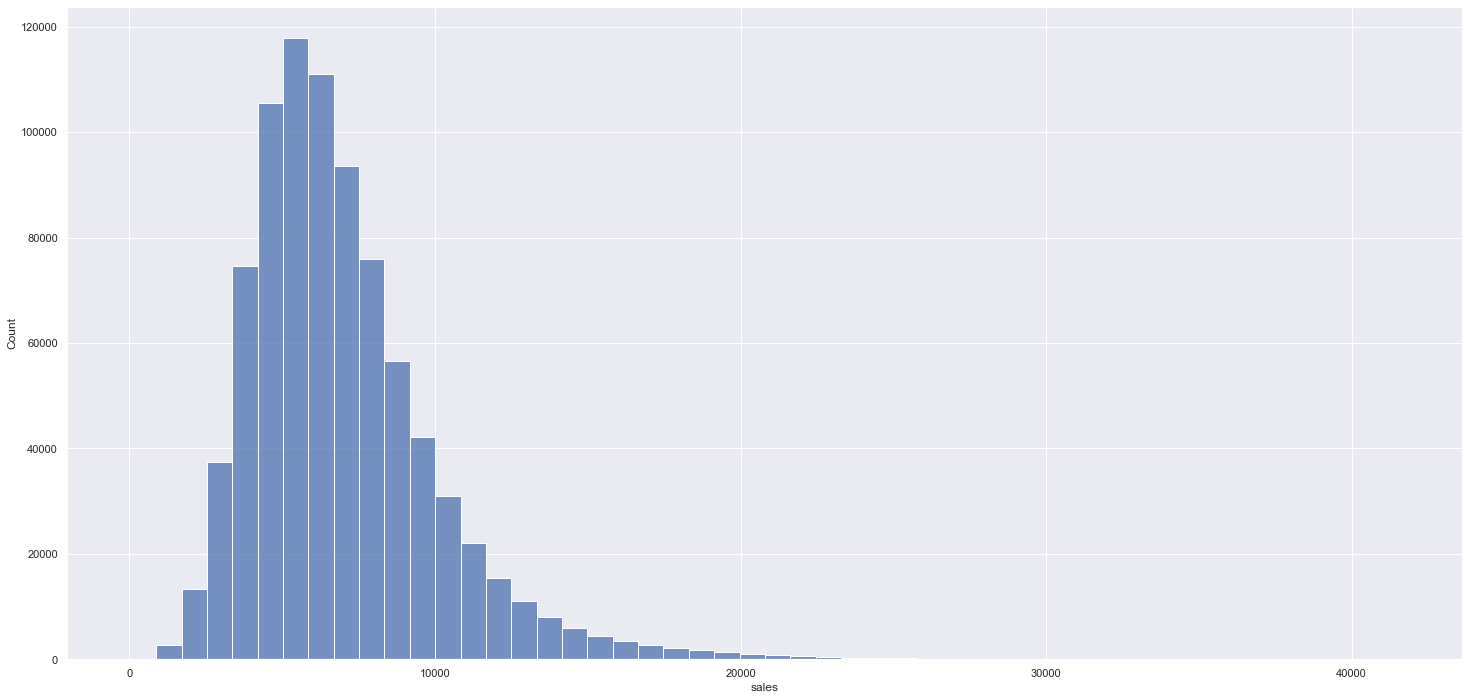

In [40]:
sns.histplot(df4['sales'], bins=50);

### 4.1.2. Numerical Variable

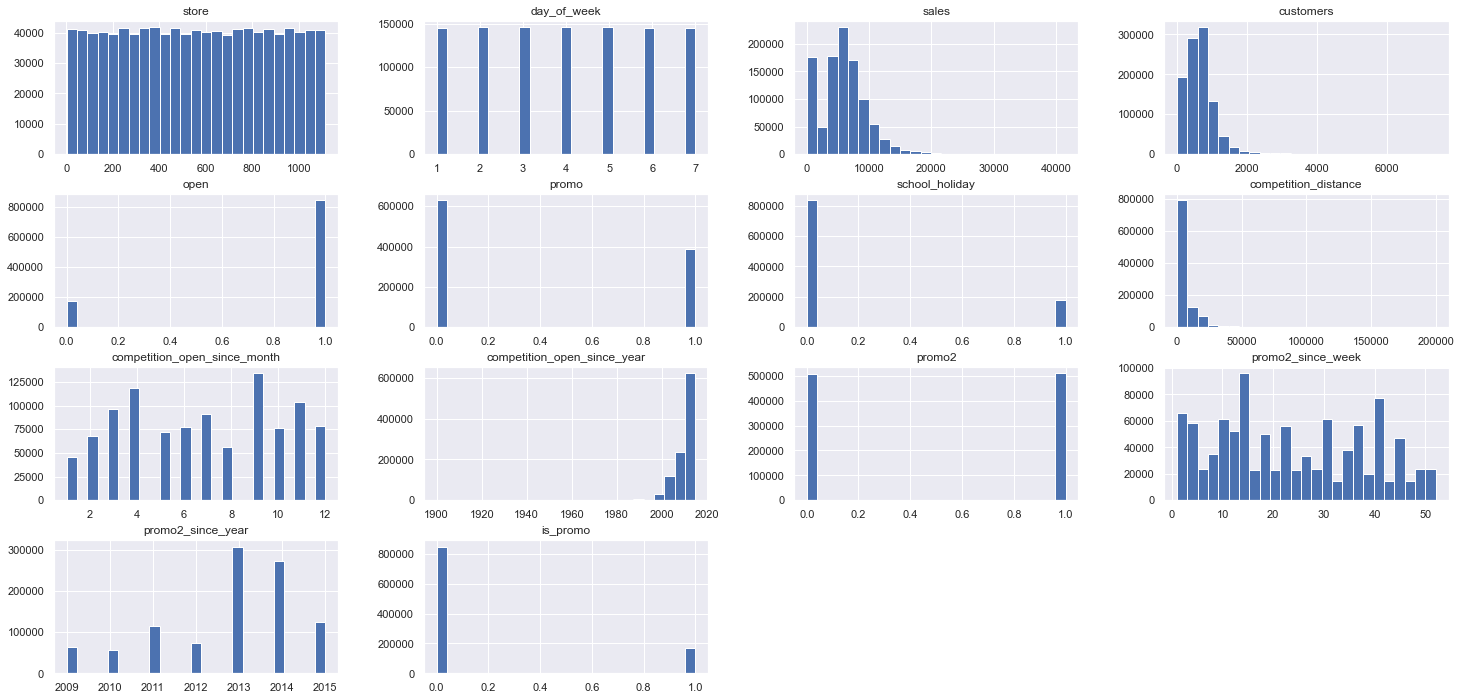

In [41]:
num_attributes.hist(bins = 25);

### 4.1.3. Categorical Variable

In [42]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

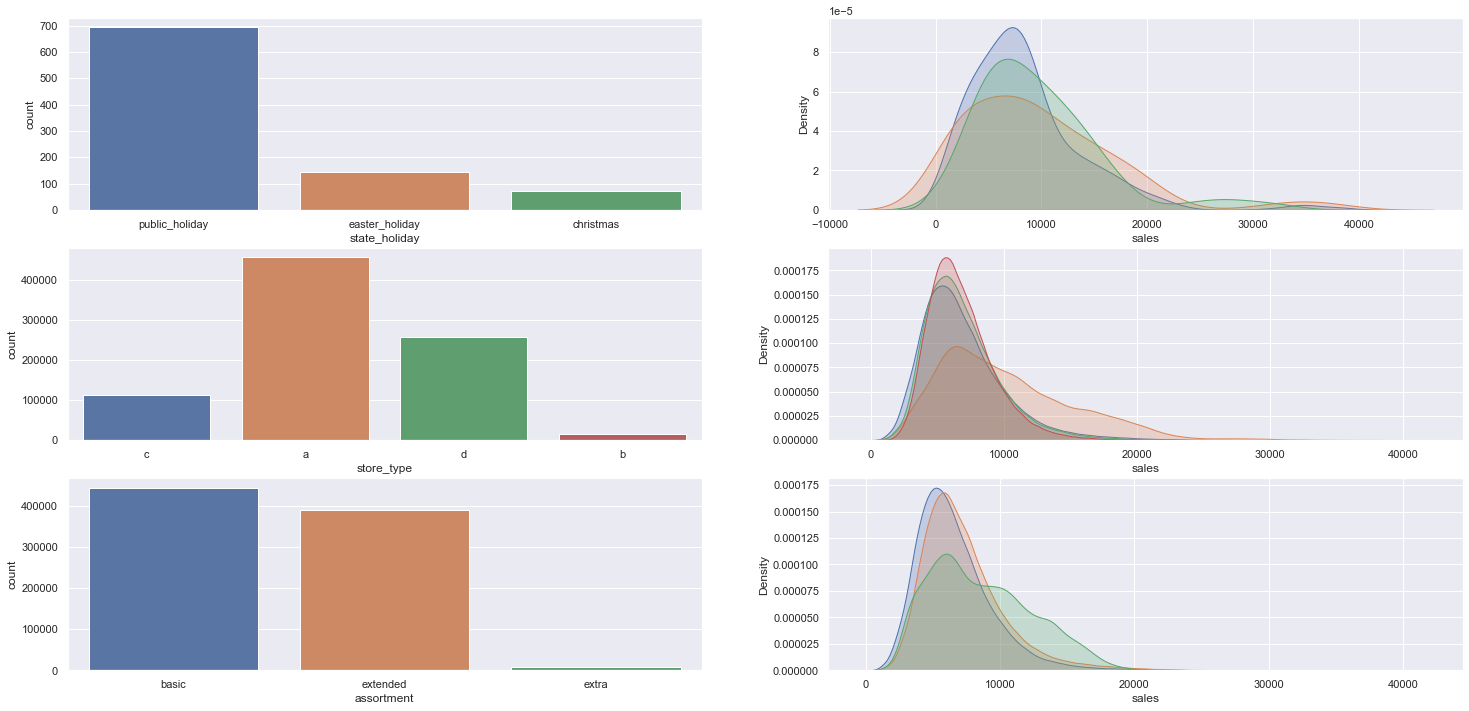

In [43]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x = a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x = df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x = df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='exra', shade=True)

## 4.2. Bivariate Analysis

### 4.2.1. Hypothesis Test

#### H1. Store with big assortment should sell more
**FALSE!** Store with BIG ASSORTMENT sells LESS 

<AxesSubplot:xlabel='year_week'>

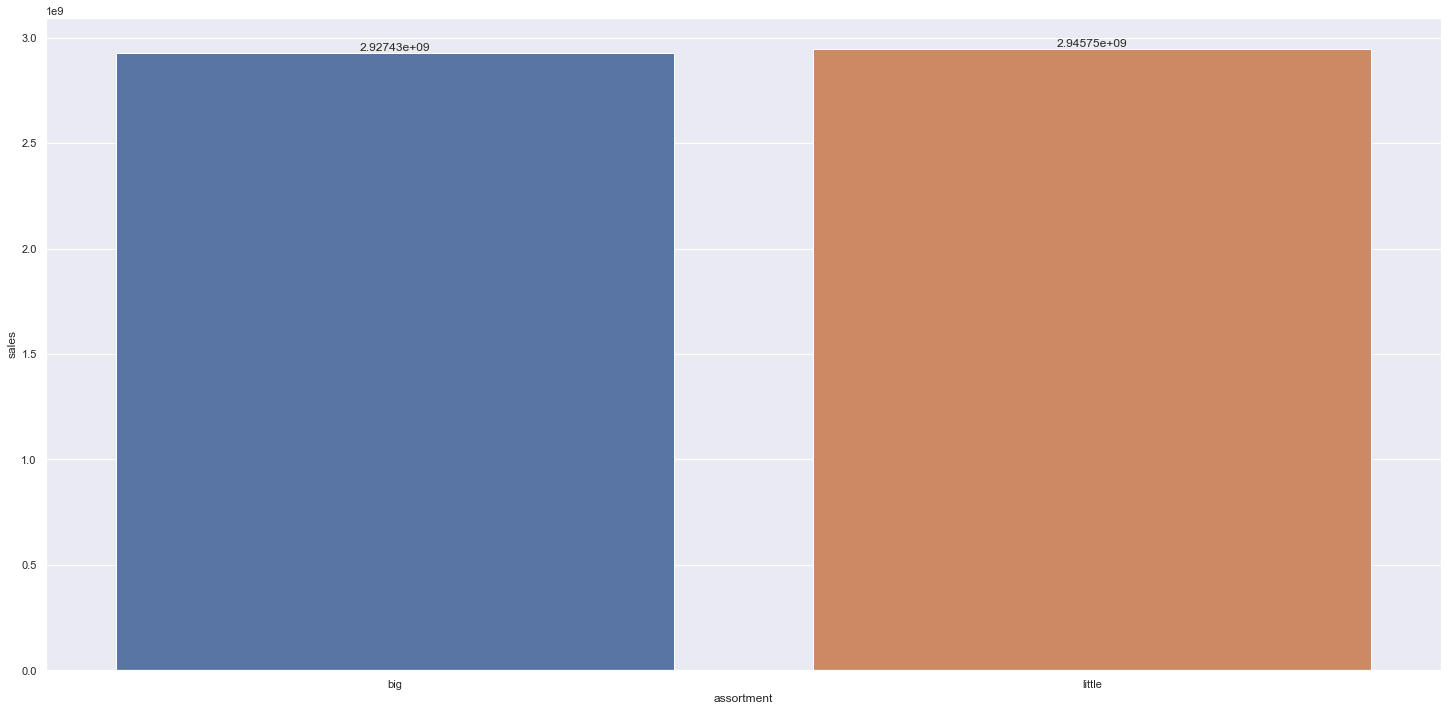

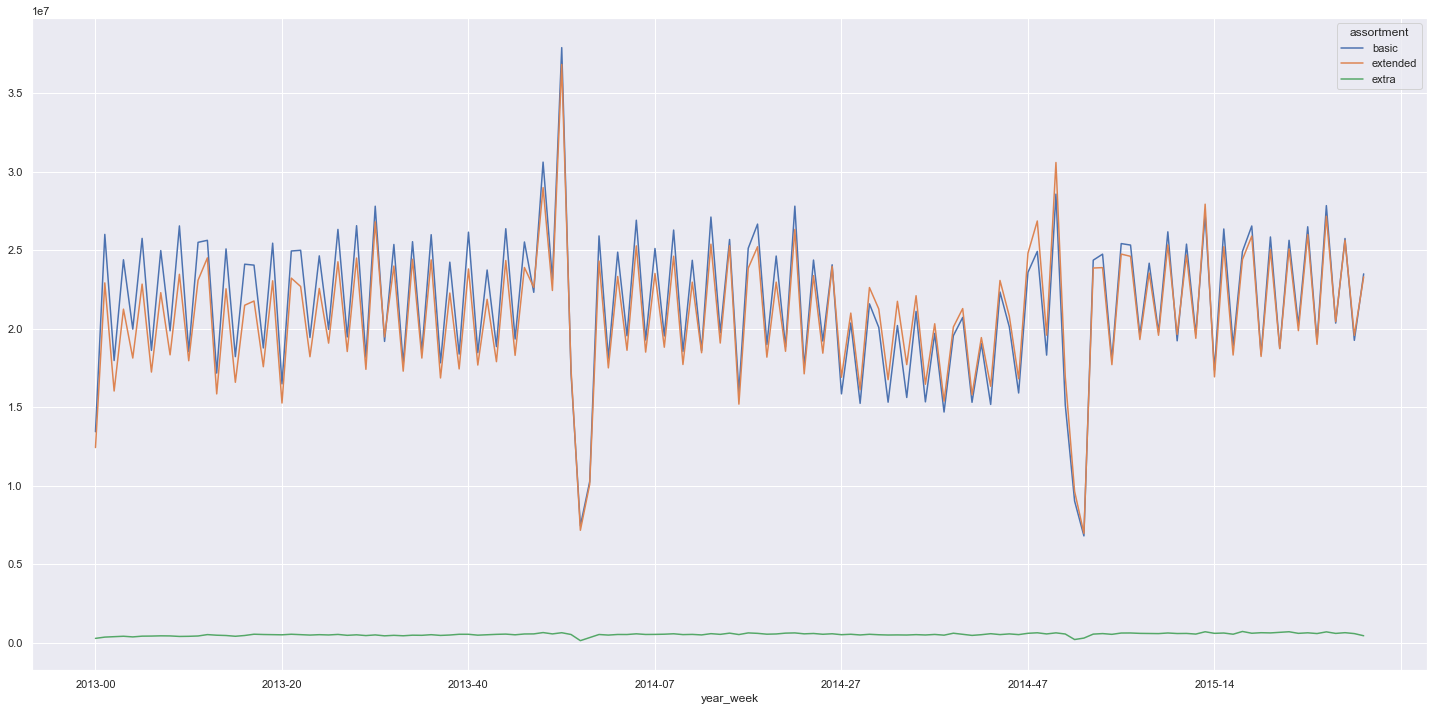

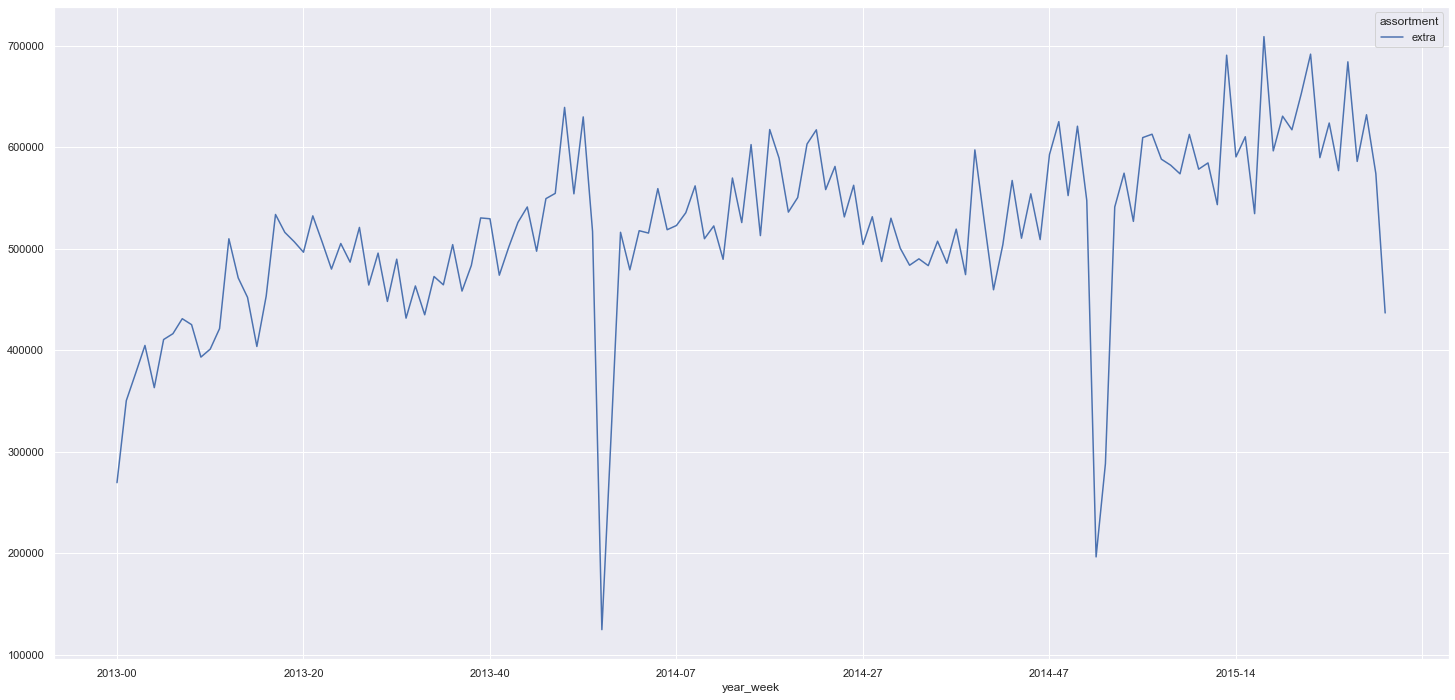

In [44]:
# aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
aux1 = df4[['assortment', 'sales']].copy()
aux1['assortment'] = df4['assortment'].apply(lambda x: 'little' if x == 'basic' else 'big')
aux1 = aux1.groupby('assortment').sum().reset_index()
ax = sns.barplot(x = 'assortment', y = 'sales', data = aux1)
ax.bar_label(ax.containers[0]);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

#### H2. Store with close competitors should sell less
**FALSE!** Store with CLOSE COMPETITIOS sells MORE

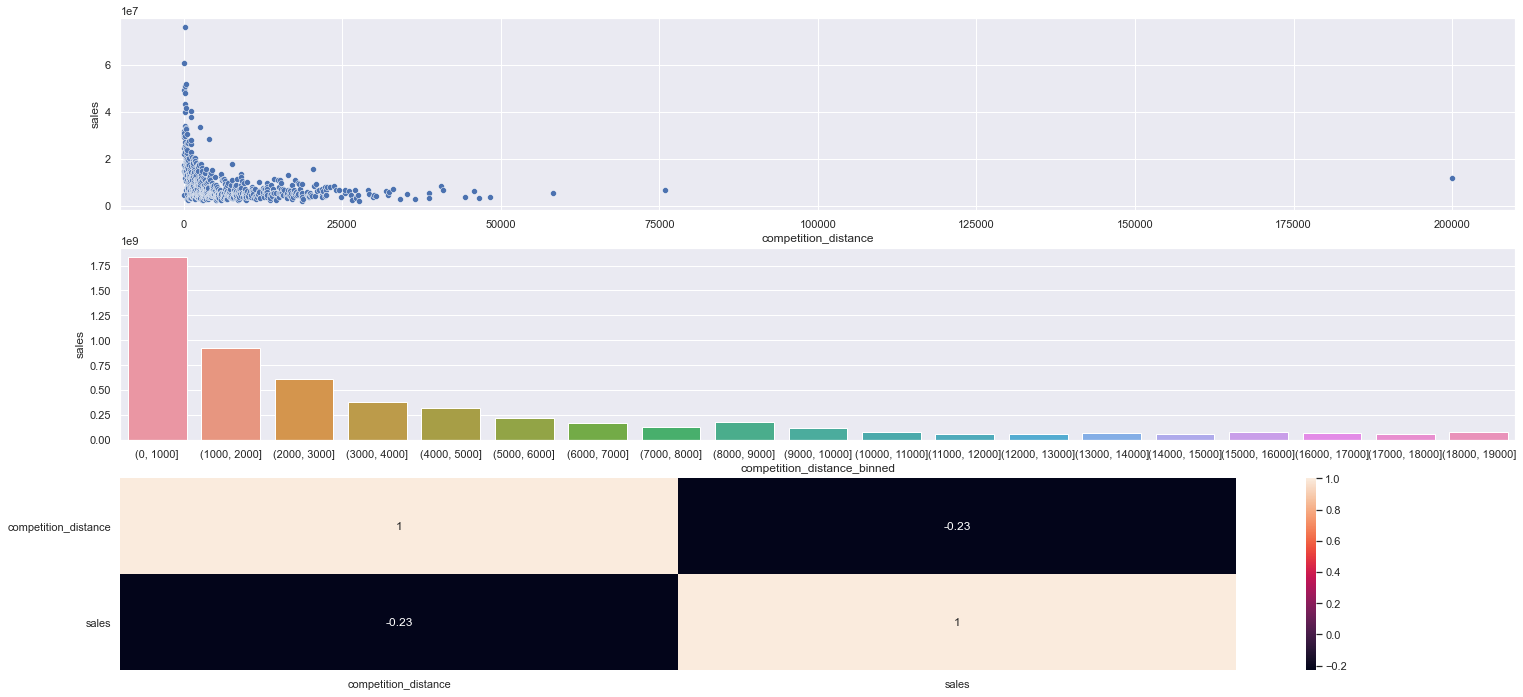

In [45]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(3, 1, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(3, 1, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
#plt.xticks(rotation = 90)

plt.subplot(3, 1, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

#### H3. Store with competitors for a long time should sell more
**FALSE!** Store with COMPETITIORS FOR A LONG TIME sells LESS

<AxesSubplot:>

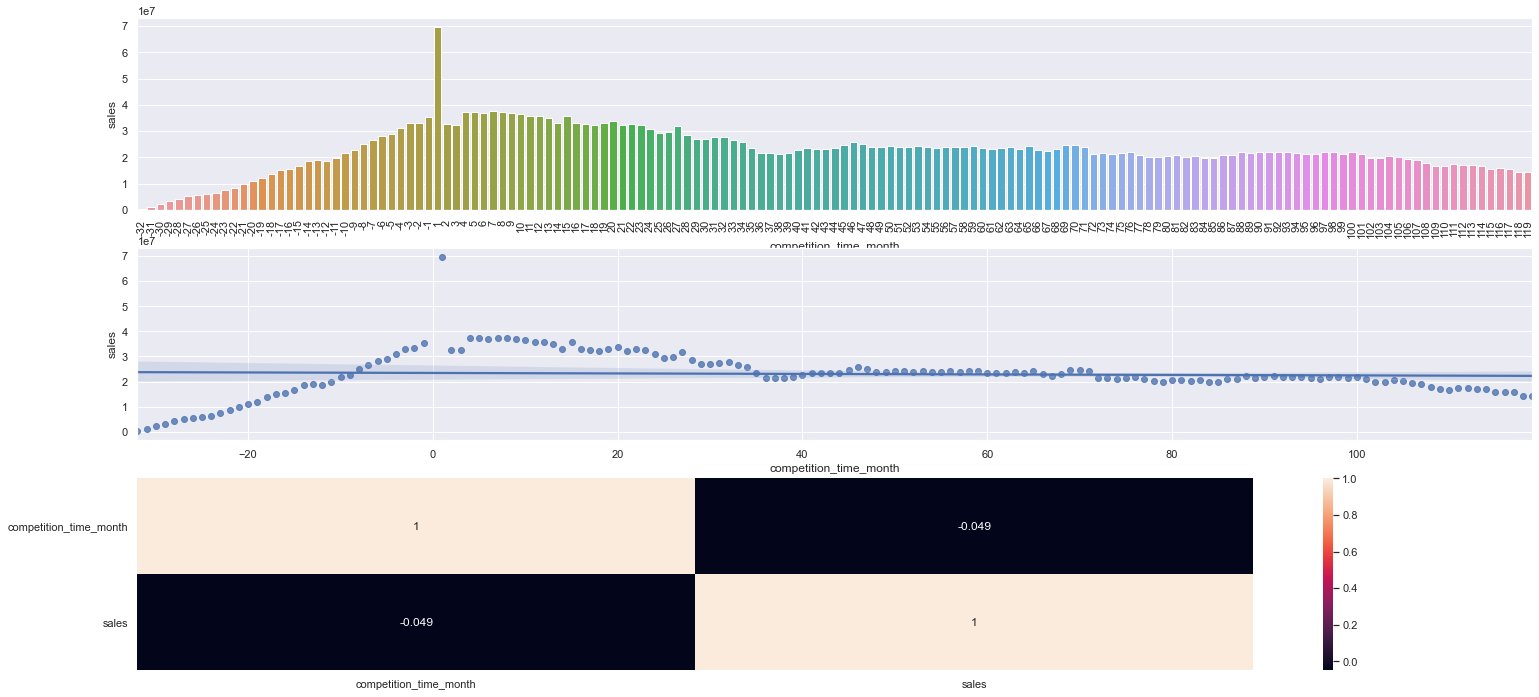

In [46]:
plt.subplot(3, 1, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(3, 1, 2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2)

plt.subplot(3, 1, 3)
sns.heatmap(aux2.corr(method = 'pearson'), annot = True)

#### H4. Store with active promotion for a long time should sell more
**FALSE!** Store with PROMO for LONG TIME sells REGULARLY and DECREASE after some time

<AxesSubplot:>

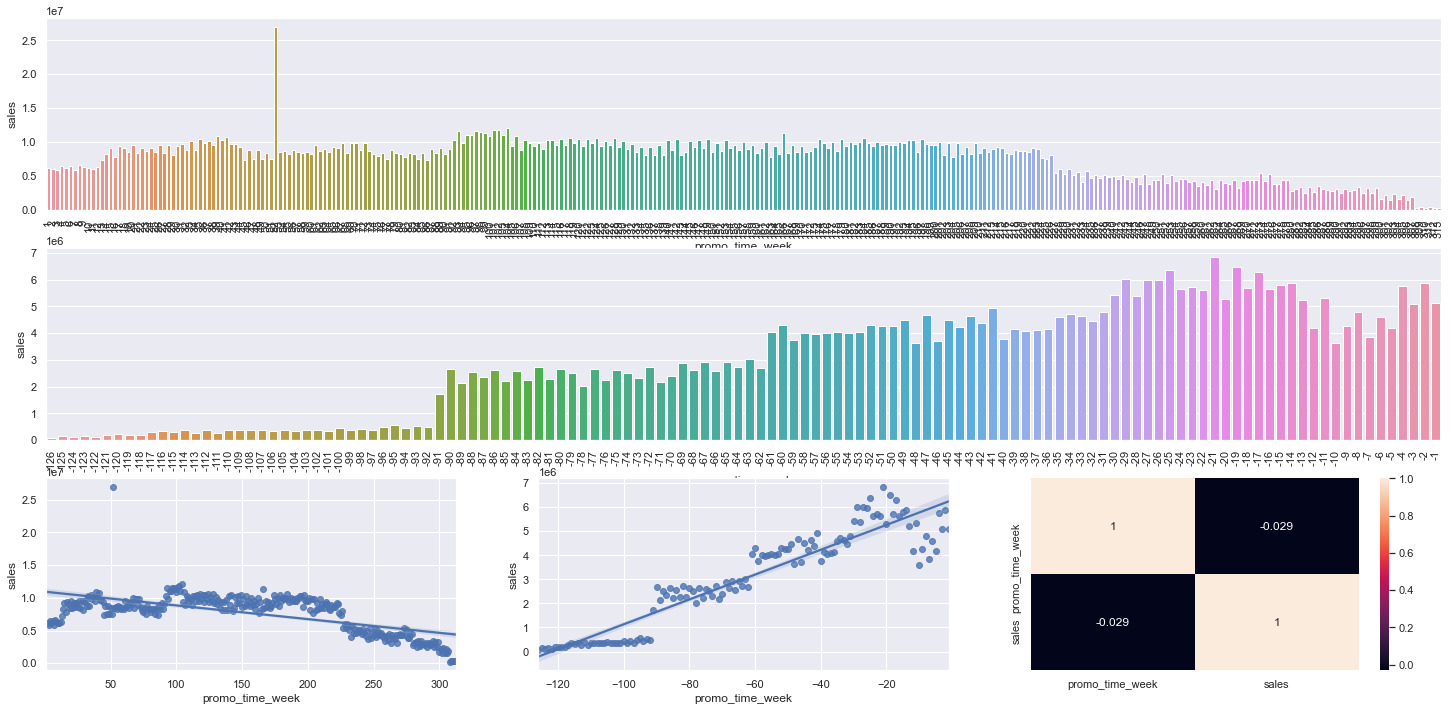

In [47]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1);

grid = GridSpec(3, 3)

plt.subplot(grid[0, :])
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promo time
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90)

plt.subplot(grid[2, 0])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1, :])
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promo time
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90)

plt.subplot(grid[2, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[2, 2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

#### <S>H5. Store with more days in promotion should sell more</S>

#### H6. Store with consecutive promotion should sell more
**FALSE!** Store with CONSECUTIVE PROMO sells LESS

In [48]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


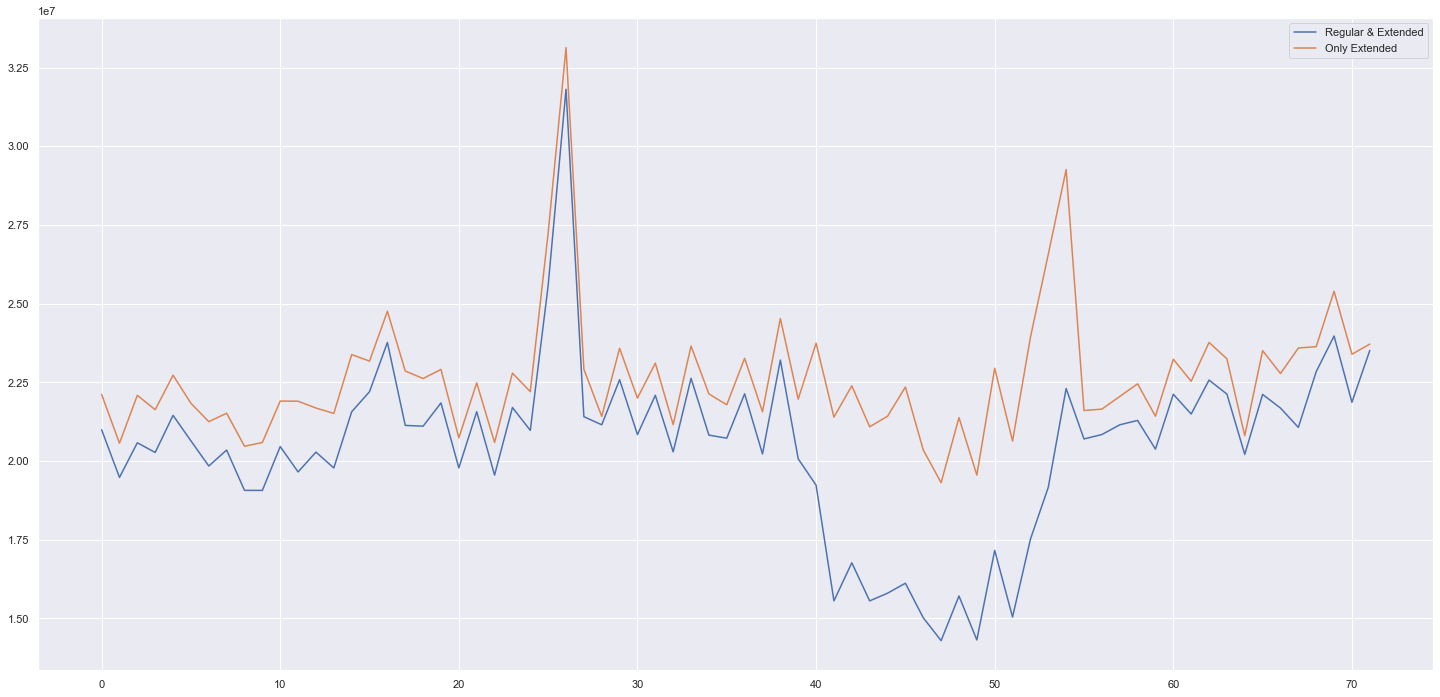

In [49]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['Regular & Extended', 'Only Extended']);

#### H7. Store opened during Christmas should sell more
**FALSE!** Store opened DURING CHRISTMAS sells LESS

<AxesSubplot:xlabel='year', ylabel='sales'>

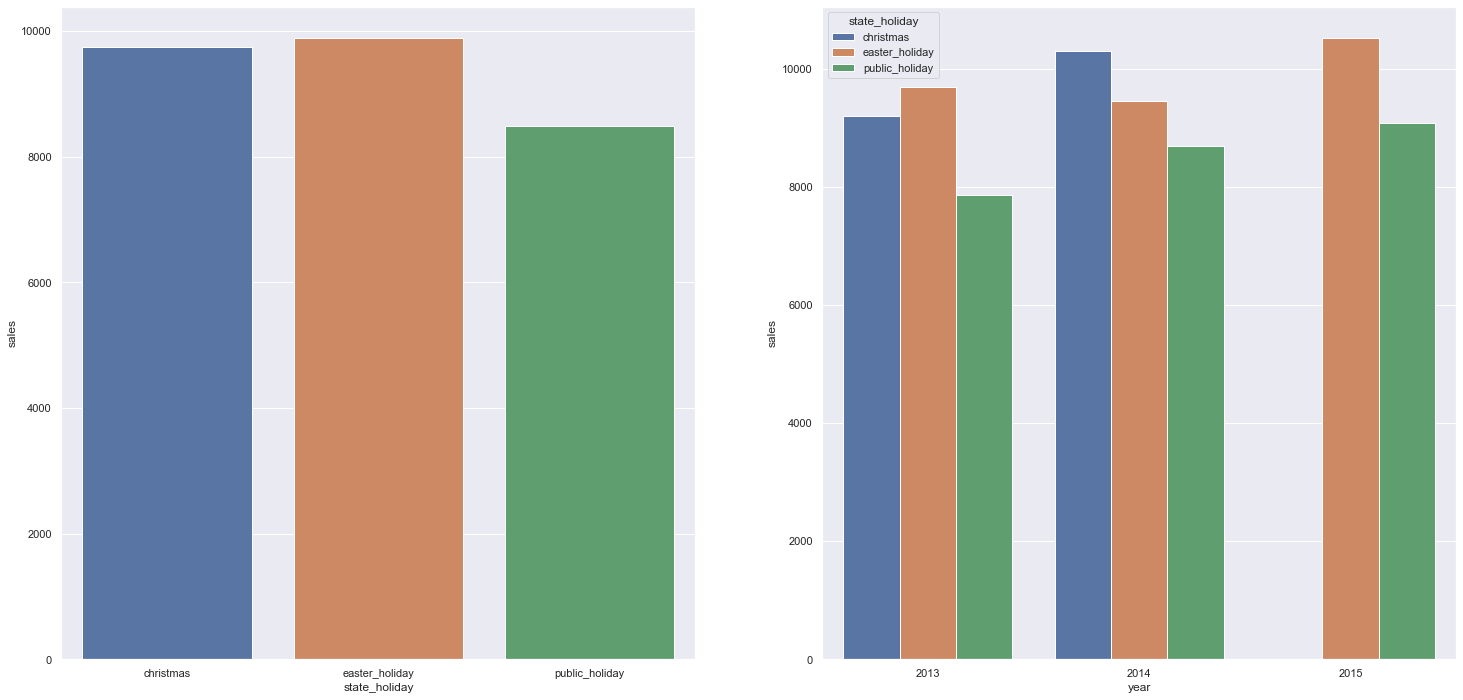

In [50]:
plt.subplot(1, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux2, hue = 'state_holiday')

#### H8. Store should sell more through the years
**FALSE!** Store sells LESS THROUGH THE YEARS

<AxesSubplot:>

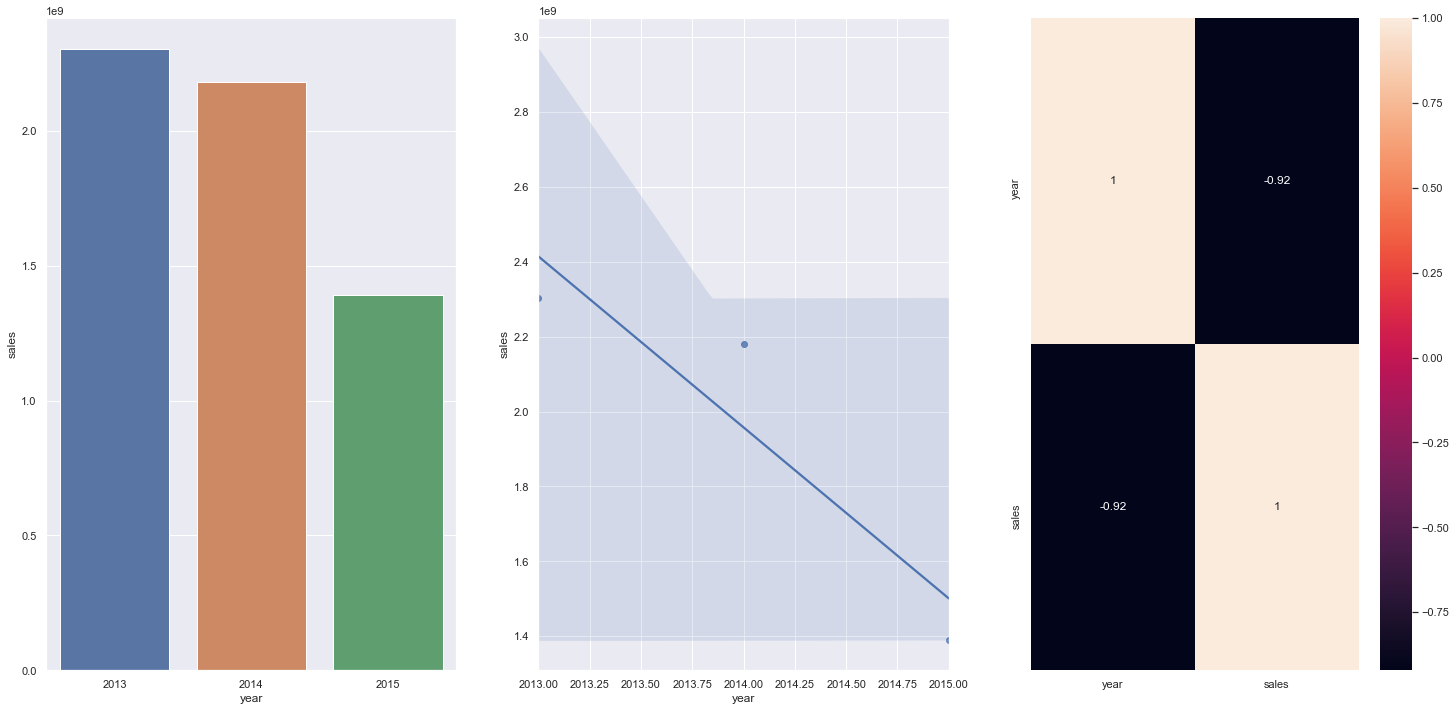

In [51]:
plt.subplot(1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

#### H9. Store should sell more in the second semester of the year
**TRUE!** Store sells a little bit MORE in the SECOND SEMESTER, if 2015 is disconsidered once it has only 7 months.

In [52]:
df4.loc[df4['year'] == 2015, 'month'].unique()

array([7, 6, 5, 4, 3, 2, 1])

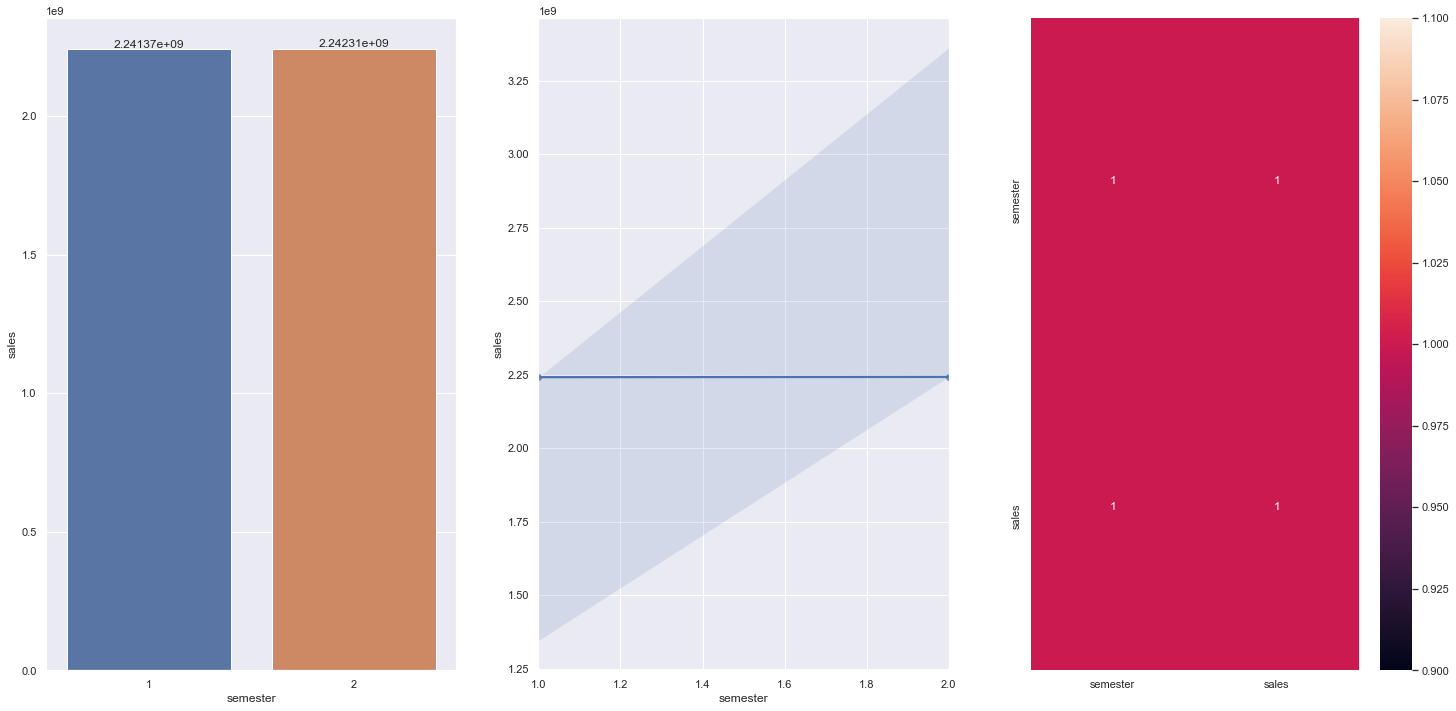

In [53]:
aux1 = df4.loc[df4['year'] < 2015, ['month', 'sales']]
aux1['semester'] = df4['month'].apply(lambda x: 1 if x < 7 else 2)

plt.subplot(1, 3, 1)
aux1 = aux1[['semester', 'sales']].groupby('semester').sum().reset_index()
ax1 = sns.barplot(x = 'semester', y = 'sales', data = aux1)
ax1.bar_label(ax1.containers[0])

plt.subplot(1, 3, 2)
ax2 = sns.regplot(x = 'semester', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
ax3 = sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

#### H10. Store should sell more after the 10th day of each month
**TRUE!**

In [54]:
# Until the 10th day may sells more if we consider the mean
# aux1 = df4[['day', 'sales']].copy()
# aux1['day'] = df4['day'].apply(lambda x: 'until 10th' if x <= 10 else 'after 10th')
# aux1 = aux1[['day', 'sales']].groupby('day').mean().reset_index()
# aux1.head()

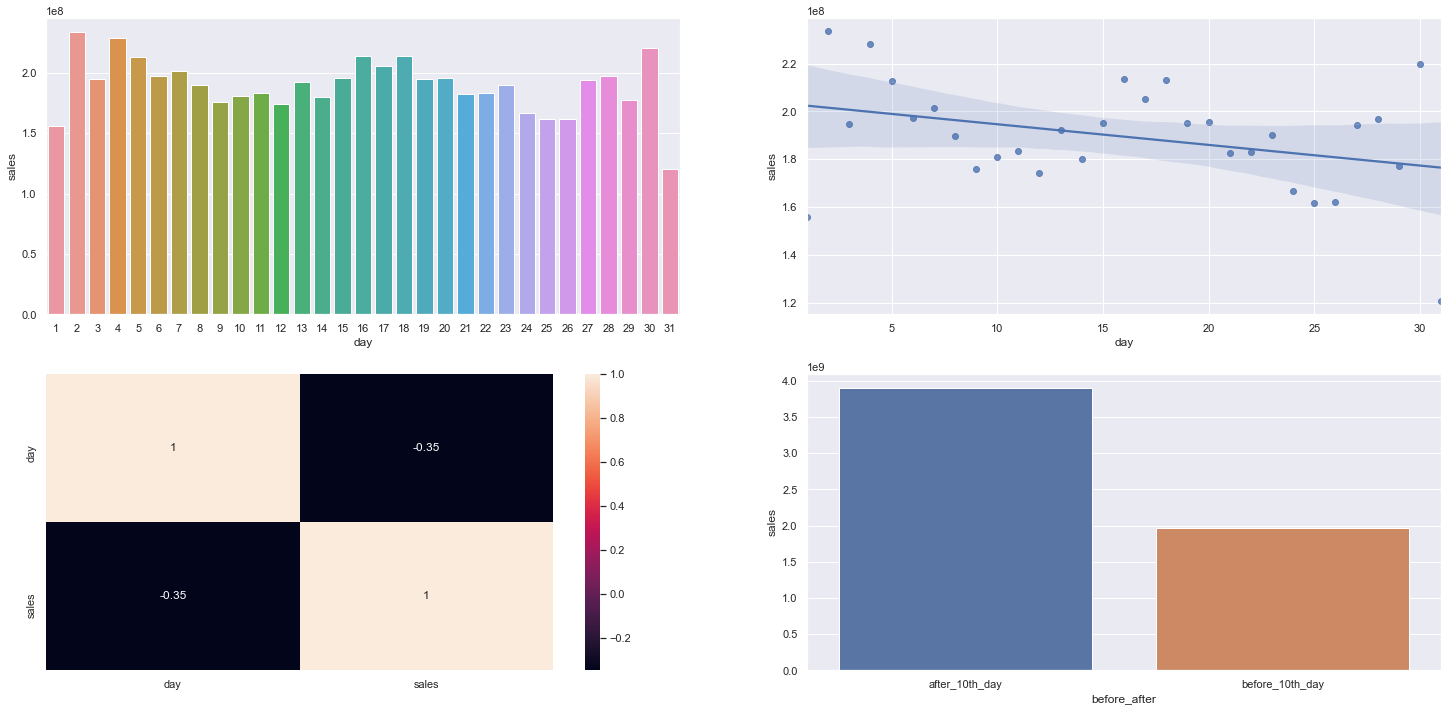

In [55]:
plt.subplot(2, 2, 1)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10th_day' if x <= 10 else 'after_10th_day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2);

#### H11. Store should sell less on weekends
**TRUE!**

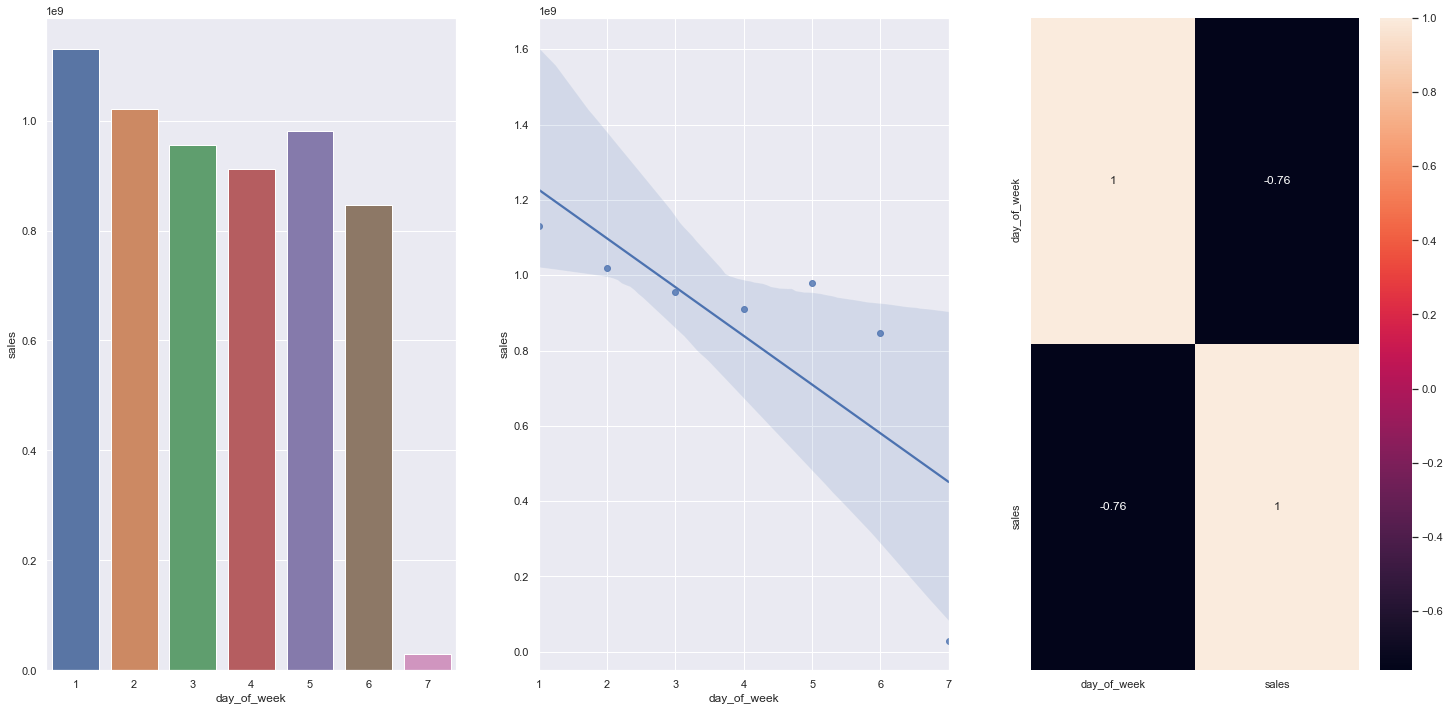

In [56]:
plt.subplot(1, 3, 1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

#### H12. Store should sell less during the school holidays
**TRUE!** Store sells LESS DURING the SCHOOL HOLIDAYS. Except for july and august.

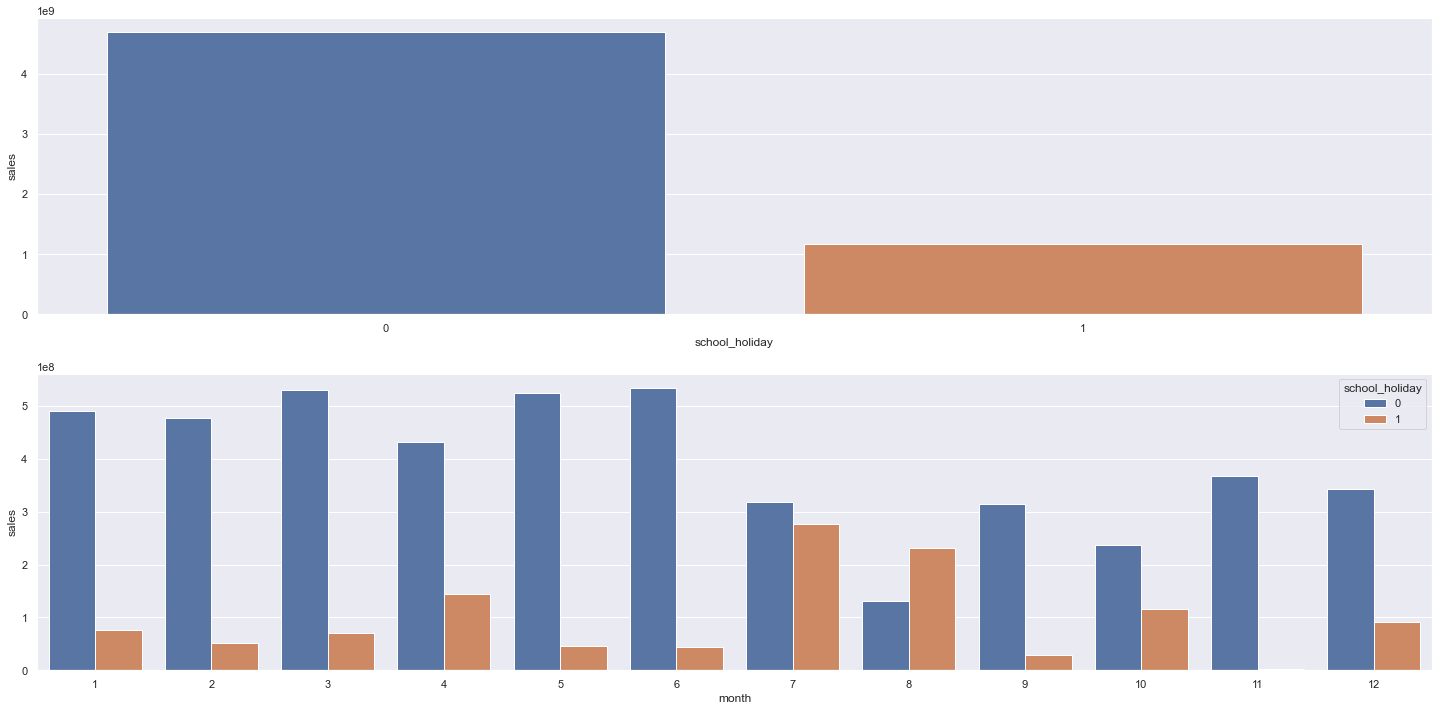

In [57]:
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['school_holiday', 'month', 'sales']].groupby(['school_holiday', 'month']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales', data = aux2, hue = 'school_holiday');

### 4.2.2. Hypothesis Summary

In [58]:
tab = [
    ['Hypothesis', 'Veredict', 'Relevance'],
    ['H1', 'False', 'Low'],
    ['H2', 'False', 'Medium'],
    ['H3', 'False', 'Medium'],
    ['H4', 'False', 'Low'],
    ['H5', '-', '-'],
    ['H6', 'False', 'Low'],
    ['H7', 'False', 'Medium'],
    ['H8', 'False', 'High'],
    ['H9', 'True',  'High'],
    ['H10', 'True', 'High'],
    ['H11', 'True', 'High'],
    ['H12', 'True', 'Low']
]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Veredict    Relevance
------------  ----------  -----------
H1            False       Low
H2            False       Medium
H3            False       Medium
H4            False       Low
H5            -           -
H6            False       Low
H7            False       Medium
H8            False       High
H9            True        High
H10           True        High
H11           True        High
H12           True        Low


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

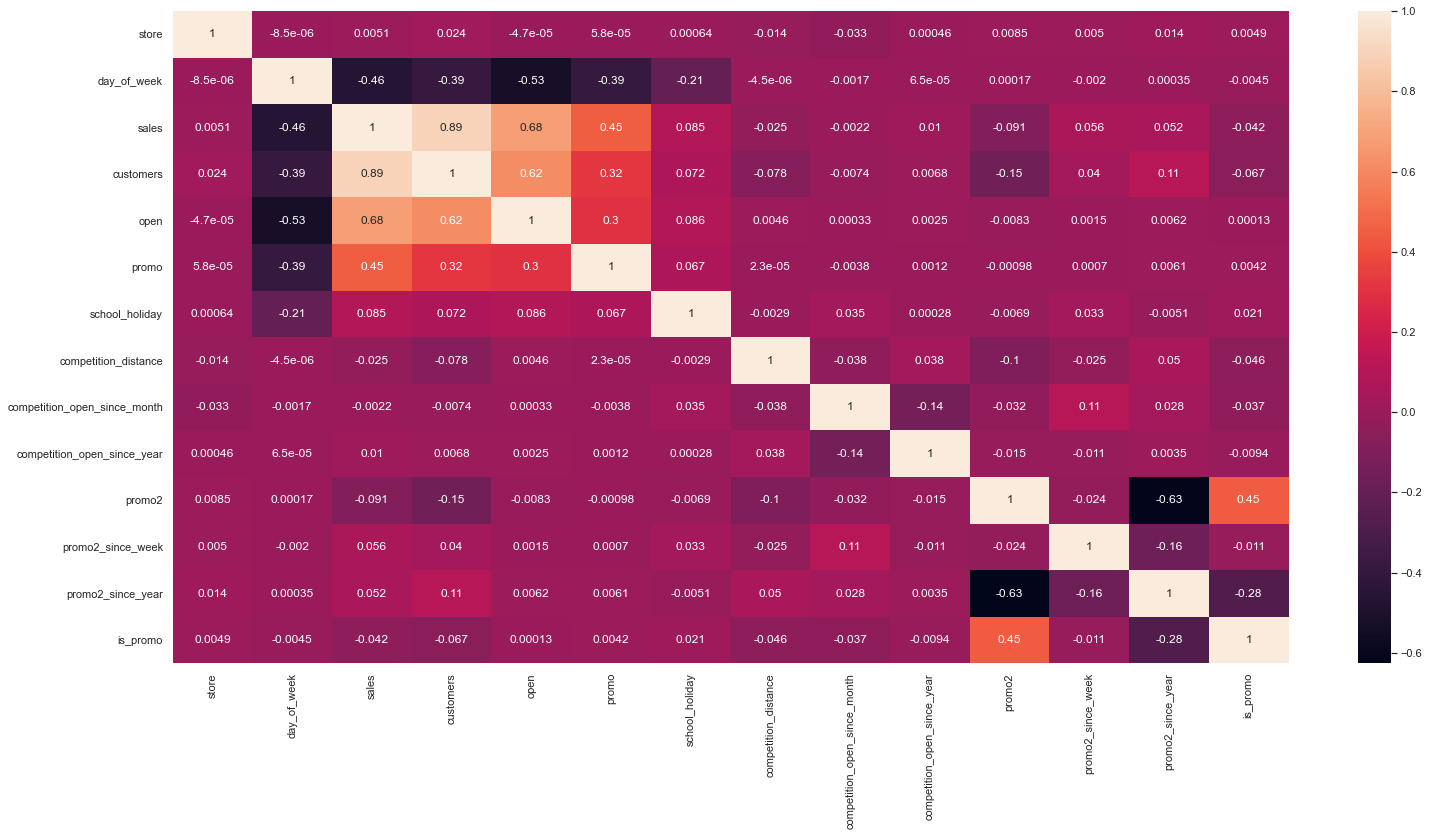

In [59]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

### 4.3.2. Categorical Attributes

In [60]:
a = df4.select_dtypes(include = 'object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [61]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]             
             })

d = d.set_index(d.columns)

d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

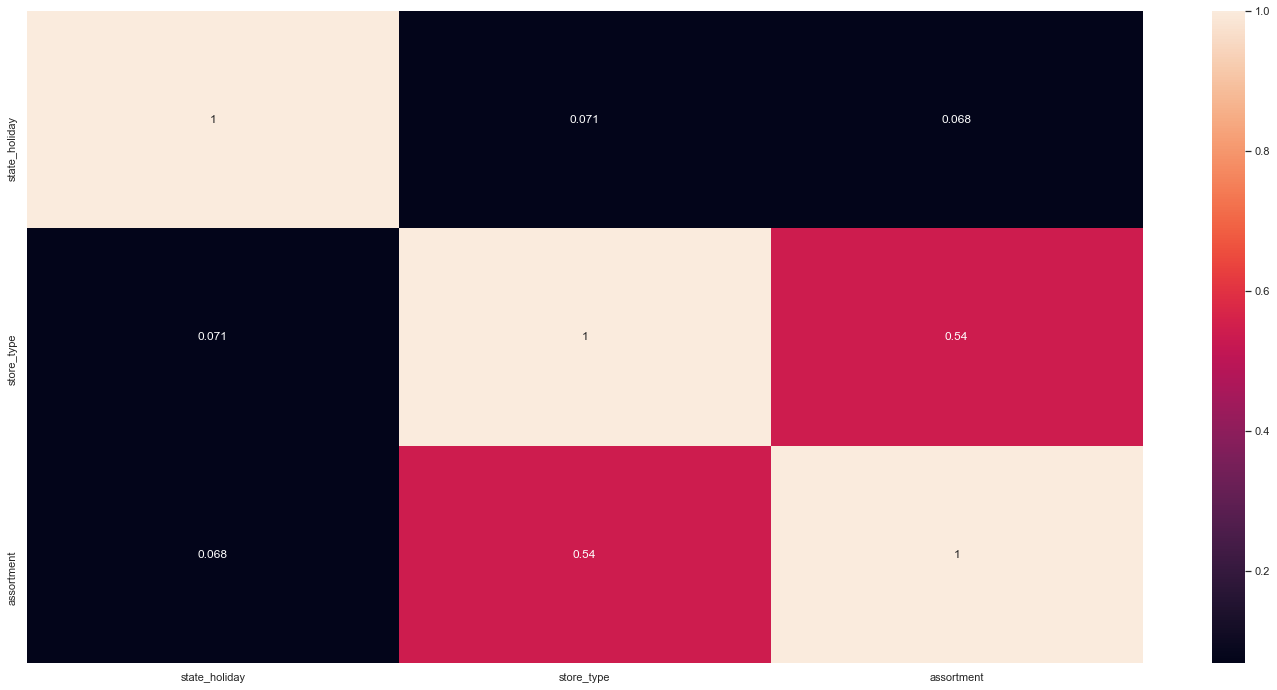

In [62]:
sns.heatmap(d, annot = True)

# 5.0 DATA PREPARATION

In [166]:
df5 = df4.copy()

## 5.1. Standardize

As the numerical attributes are not normal, it was defined that will not be needed to standardize them

## 5.2. Rescaling

In [176]:
df_aux = df5.copy()

In [177]:
# competition distance: robust scaler (it has outliers)
comp_dist_path = '../asset/pickle/competition_distance_scaler.pkl'
comp_dist_pkl = pickle.load(open(comp_dist_path, 'rb'))
df5['competition_distance'] = comp_dist_pkl.transform(df5[['competition_distance']].values)

# year: min max scaler (it has not relevant outliers)
year_path = '../asset/pickle/year_scaler.pkl'
year_pkl = pickle.load(open(year_path, 'rb'))
df5['year'] = year_pkl.transform(df5[['year']].values)

# competition time month: robust scaler (it has outliers)
comp_time_path = '../asset/pickle/competition_time_month_scaler.pkl'
comp_time_pkl = pickle.load(open(comp_time_path, 'rb'))
df5['competition_time_month'] = comp_time_pkl.transform(df5[['competition_time_month']].values)

# promo time week: min max scaler (it has not relevant outliers)
promo_time_path = '../asset/pickle/promo_time_week_scaler.pkl'
promo_time_pkl = pickle.load(open(promo_time_path, 'rb'))
df5['promo_time_week'] = promo_time_pkl.transform(df5[['promo_time_week']].values)

In [174]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance: robust scaler (it has outliers)
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('../asset/pickle/competition_distance_scaler.pkl', 'wb'))

# year: min max scaler (it has not relevant outliers)
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('../asset/pickle/year_scaler.pkl', 'wb'))

# competition time month: robust scaler (it has outliers)
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('../asset/pickle/competition_time_month_scaler.pkl', 'wb'))

# promo time week: min max scaler (it has not relevant outliers)
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('../asset/pickle/promo_time_week_scaler.pkl', 'wb'))

## 5.3. Transform

### 5.3.1. Encoding

In [179]:
store_type_path = '../asset/pickle/store_type_scaler.pkl'
store_type_pkl = pickle.load(open(store_type_path, 'rb'))
df5['store_type'] = story_type_pkl.transform(df5['store_type'])

In [180]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,2,basic,-0.375834,9,2008,0,31,2015,0,-1006.0,7,31,31,2015-30,2008-09-01,-0.203798,2015-07-27,0.287670
1,2,5,2015-07-31,6064,1,regular_day,1,0,basic,-0.375852,11,2007,1,13,2010,1,-1006.0,7,31,31,2015-30,2007-11-01,-0.201972,2010-03-22,0.289117
2,3,5,2015-07-31,8314,1,regular_day,1,0,basic,-0.375499,12,2006,1,14,2011,1,-1006.0,7,31,31,2015-30,2006-12-01,-0.199963,2011-03-28,0.288842
3,4,5,2015-07-31,13995,1,regular_day,1,2,extended,-0.375851,9,2009,0,31,2015,0,-1006.0,7,31,31,2015-30,2009-09-01,-0.206172,2015-07-27,0.287670
4,5,5,2015-07-31,4822,1,regular_day,1,0,basic,-0.375089,4,2015,0,31,2015,0,-1006.0,7,31,31,2015-30,2015-04-01,-0.218408,2015-07-27,0.287670


In [34]:
le = LabelEncoder()

# state_holiday: one hot encoding (status change)
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type: label encoder (it has no relation between the levels of the variable)
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('../asset/pickle/store_type_scaler.pkl', 'wb'))

# assortment: ordinal encoder (it has ordinal relation between the levels[extended > extra > basic])
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transform

In [85]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transform

In [35]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

# 6.0. FEATURE SELECTION

In [36]:
df6 = df5.copy()

## 6.1. Split the Dataframe into training and test

In [41]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [42]:
# getting the date of 6 weeks before the last date in the dataframe
cut_date = df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

In [43]:
# training dataset
x_train_split = df6[df6['date'] < cut_date]
y_train_split = x_train_split['sales']

# test dataset
x_test_split = df6[df6['date'] >= cut_date]
y_test_split = x_test_split['sales']

print(f"Training Min Date: {x_train_split['date'].min()}")
print(f"Training Max Date: {x_train_split['date'].max()}")

print(f"\nTraining Min Date: {x_test_split['date'].min()}")
print(f"Training Max Date: {x_test_split['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Training Min Date: 2015-06-19 00:00:00
Training Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [91]:
# # training and test dataset for Boruta
# x_train_n = x_train_split.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train_split.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

In [92]:
# cols_selected = boruta.support_.tolist()

# x_train_fs = x_train_split.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Features Selected

In [37]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos'
]

# features to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [94]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [95]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0. MACHINE LEARNING MODELING

In [45]:
x_train = x_train_split[cols_selected_boruta]
y_train = y_train_split

x_test = x_test_split[cols_selected_boruta]
y_test = y_test_split

x_training = x_train_split[cols_selected_boruta_full]

## 7.1. Average Model

In [46]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## 7.2.1. Linear Regression Model

In [189]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.2.2. Linear Regression Model - Cross Validation

In [190]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression CV', lr)
lr_result_cv

,MODEL,MAE CV,MAPE CV,RMSE CV
0,Linear Regression CV,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3.1. Linear Regression Regularized Model

In [191]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1891.704881,0.289106,2744.451737


## 7.3.2. Linear Regression Regularized Model - Cross Validation

In [192]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Regularized CV', lrr)
lrr_result_cv

,MODEL,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized CV,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4.1. Random Forest Regressor

In [193]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


## 7.4.2. Random Forest Regressor - Cross Validation

In [194]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor CV', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MODEL,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor CV,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


## 7.5.1. XGBoost Regressor

In [200]:
# model
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    eta=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.9 
).fit(x_train, y_train)

# predict
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

XGBoostError: sklearn needs to be installed in order to use this module

## 7.5.2. XGBoost Regressor - Cross Validation

In [79]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor CV', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MODEL,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor CV,7049.2 +/- 588.65,0.95 +/- 0.0,7715.2 +/- 689.51


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [80]:
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.423528,0.949439,7330.693347


### 7.6.2. Real Performance - Cross Validation

In [81]:
modeling_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modeling_result.sort_values('RMSE CV')

,MODEL,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor CV,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,Linear Regression CV,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression Regularized CV,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor CV,7049.2 +/- 588.65,0.95 +/- 0.0,7715.2 +/- 689.51


# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [82]:
# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]
# }

# MAX_EVAL = 15

In [83]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # choose values for parameters randomly
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items() }
#     print(hp)
    
#     # model
#     model_xgb = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=hp['n_estimators'],
#         eta=hp['eta'],
#         max_depth=hp['max_depth'],
#         subsample=hp['subsample'],
#         colsample_bytree=hp['colsample_bytree'],
#         min_child_weight=hp['min_child_weight']
#     )

#     # performance
#     result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
#     final_result = pd.concat([final_result, result])
    
# final_result

## 8.2. Final Model

In [47]:
param_tuned = {
    'n_estimators': 1500,
    'eta': 0.3,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytree': 0.9,
    'min_child_weight': 8
}

In [48]:
# model
model_xgb_tuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=param_tuned['n_estimators'],
    eta=param_tuned['eta'],
    max_depth=param_tuned['max_depth'],
    subsample=param_tuned['subsample'],
    colsample_bytree=param_tuned['colsample_bytree'],
    min_child_weight=param_tuned['min_child_weight']
).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor Tuned', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

KeyboardInterrupt: 

In [ ]:
pe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
pe

# 9.0. ERROR TRANSLATION

In [101]:
df9 = x_test_split[cols_selected_boruta_full]

# # rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [102]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, on='store', how='inner')
df92 = pd.merge(df91, df9_aux3, on='store', how='inner')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Columns ordering
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [103]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108295.875000,104902.626362,111689.123638,3393.248638,0.613165
908,909,249936.734375,242554.163680,257319.305070,7382.570695,0.510055
875,876,176925.234375,172485.408925,181365.059825,4439.825450,0.330552
182,183,201341.937500,199482.473806,203201.401194,1859.463694,0.299339
1038,1039,348707.406250,347004.978054,350409.834446,1702.428196,0.225578


<AxesSubplot:xlabel='store', ylabel='MAPE'>

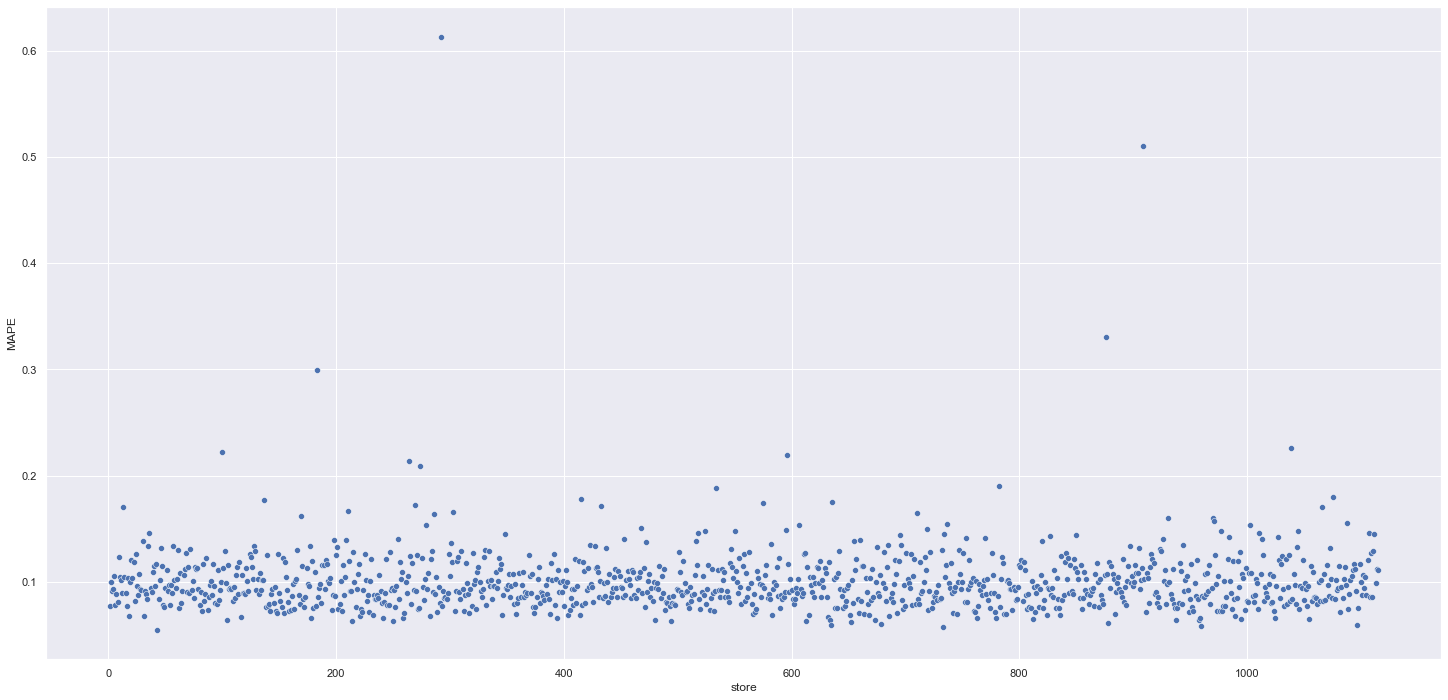

In [104]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2. Total Performance

In [105]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$281,857,952.00"
1,worst_scenario,"R$281,083,969.18"
2,best_scenario,"R$282,631,934.02"


## 9.3. Machine Learning Performance

In [106]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

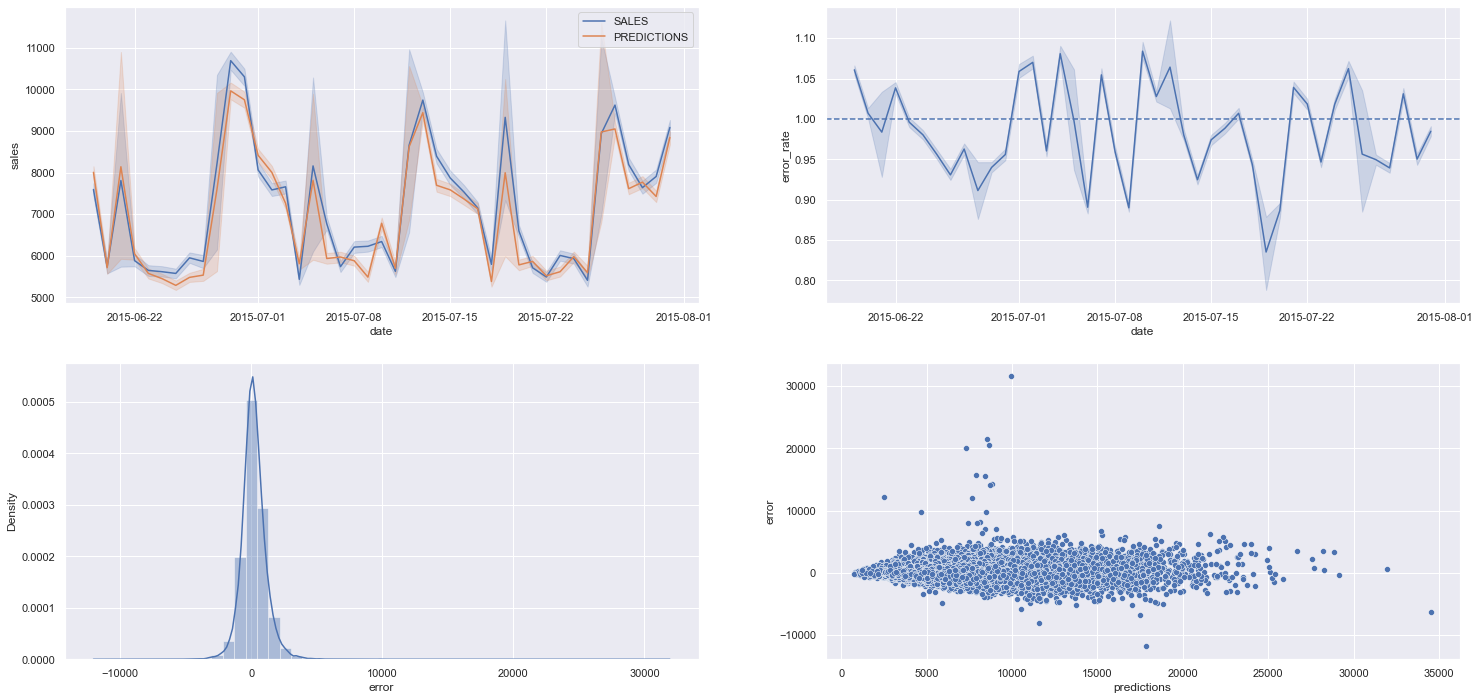

In [107]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])

# 10.0. DEPLOY MODEL TO PRODUCTION

In [108]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open('../models/model_rossmann.pkl', 'wb'))

## 10.1. Rossmann Class

In [109]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path='/home/bem/repos/rossmann_sales_predict/rossmann_sales_predict/'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'asset/pickle/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'asset/pickle/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'asset/pickle/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'asset/pickle/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'asset/pickle/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):

        ## 1.1. Rename Columns

        cols_old = df1.columns
        f_snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(f_snakecase, cols_old))
        df1.columns = cols_new
        

        ## 1.3. Data Types
        
        df1['date'] = pd.to_datetime(df1['date'])
        

        ## 1.5. Fillout NA

        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply(lambda x:
                                                                                                  x['date'].month if math.isnan(x['competition_open_since_month'])
                                                                                                  else x['competition_open_since_month'],
                                                                                                  axis=1
                                                                                                 )

        # competition_open_since_year
        df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply(lambda x:
                                                                                                x['date'].year if math.isnan(x['competition_open_since_year'])
                                                                                                else x['competition_open_since_year'],
                                                                                                axis=1
                                                                                               )

        # promo2_since_week
        df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(lambda x:
                                                                            x['date'].week if math.isnan(x['promo2_since_week'])
                                                                            else x['promo2_since_week'],
                                                                            axis=1
                                                                           )

        # promo2_since_year
        df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x:
                                                                            x['date'].year if math.isnan(x['promo2_since_year'])
                                                                            else x['promo2_since_year'],
                                                                            axis=1
                                                                           )

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x:
                                                                    0 if x['promo_interval'] == 0
                                                                    else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                                    else 0,
                                                                    axis=1
                                                                    )


        ## 1.6. Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    
    def feature_engineering(self, df2):
        
        # FEATURE ENGINEERING
        ## 2.4. Feature Engineering

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(
            lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                        month=x['competition_open_since_month'],
                                        day=1),
            axis=1)

        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /
                                         30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(
            str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply(
            lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w'
                                                 ) - datetime.timedelta(days=7))

        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /
                                  7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(
            lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(
            lambda x: 'public_holiday' if x == 'a' else 'easter_holiday'
            if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        df2.sample(9).T

        
        # 3.0. FILTERING OF VARIABLES
        ## 3.1. Filteting Lines

        df2 = df2[df2['open'] != 0]

        
        ## 3.2. Filtering Columns

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)

        return df2
    
    def data_preparation(self, df5):
        
        # 5.0 DATA PREPARATION
        ## 5.2. Rescaling

        # competition distance: robust scaler (it has outliers)
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # year: min max scaler (it has not relevant outliers)
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        # competition time month: robust scaler (it has outliers)
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo time week: min max scaler (it has not relevant outliers)
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        
        ## 5.3. Transform
        ### 5.3.1. Encoding

        # state_holiday: one hot encoding (status change)
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type: label encoder (it has no relation between the levels of the variable)
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment: ordinal encoder (it has ordinal relation between the levels[extended > extra > basic])
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        
        ### 5.3.3. Nature Transform

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

        cols_selected = [
            'store',
            'promo',
            'store_type',
            'assortment',
            'competition_distance',
            'competition_open_since_month',
            'competition_open_since_year',
            'promo2',
            'promo2_since_week',
            'promo2_since_year',
            'competition_time_month',
            'promo_time_week',
            'day_of_week_sin',
            'day_of_week_cos',
            'month_sin',
            'month_cos',
            'day_sin',
            'day_cos',
            'week_of_year_sin',
            'week_of_year_cos'
        ]
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into te original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API Handler

In [111]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Loading model
model = pickle.load(open('/home/bem/repos/rossmann_sales_predict/rossmann_sales_predict/rossmann_sales_predict/models/model_rossmann.pkl', 'rb'))

# Initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        
        if isinstance(test_json, dict):
            
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else:
            
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
    
    
        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # predict
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [42]:
# merge test dataset with Store
df_test = pd.merge(df_test_raw, df_store_raw, how='left', on='Store')

# choose store for prediction
# df_test = df_test[df_test['Store'].isin([183, 22, 12])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [43]:
len(df_test[df_test['Store'] == 183])

40

In [44]:
df_test['Date'].sort_values().unique()

array(['2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
       '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
       '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
       '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
       '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
       '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
       '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
       '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
       '2015-09-02', '2015-09-03', '2015-09-04', '2015-09-05',
       '2015-09-06', '2015-09-07', '2015-09-08', '2015-09-09',
       '2015-09-10', '2015-09-11', '2015-09-12', '2015-09-13',
       '2015-09-14', '2015-09-15', '2015-09-16', '2015-09-17'],
      dtype=object)

In [12]:
# convert DataFrame to JSON
data = json.dumps(df_test.to_dict(orient='records'))

In [13]:
# Tipo de chamada
call_type = 'top prediction'
call_type = 'top sales'
call_type = 'filter'
call_type = 'start'
call_type = 'help'

# API Call
url = 'http://192.168.0.27:5000/rossmann/predict'
#url = 'http://0.0.0.0:5000/rossmann/predict'
#url = 'https://sales-predict-rossmann.herokuapp.com/rossmann/predict'
#url = 'https://das-rossmann-prediction.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)

print(f"Status Code {r.status_code}")

Status Code 200


In [14]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [15]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index().sort_values(by='prediction')

# for i in range(len(d2)):
#     print(f"Store Number {d2.loc[i, 'store']} will sell R${d2.loc[i, 'prediction']:,.2f} in the next 6 weeks")

In [16]:
d2[d2['store'] == 183]

,store,prediction
139,183,273747.917725


In [17]:
d2.head()

,store,prediction
419,543,106307.931763
543,703,114355.331909
337,435,114867.811035
741,956,121917.268799
168,219,123845.683594


In [18]:
d2[d2['store'] == 183]

,store,prediction
139,183,273747.917725


In [26]:
# Top 5 maiores previsões
# df_top5 = d2.sort_values(by='prediction', ascending=False).head(5)
# fig = sns.barplot(x='store', y='prediction', data=df_top5)
# fig.set_title('Rossmann Sales Store Prediction')
# fig.set_ylabel('Predicion for next 6 weeks (Unit: K)')
# fig.set_xlabel('Store ID')

# ylabels = ['{:,.0f}'.format(x) + 'K' for x in fig.get_yticks()/1000]
# fig.set_yticklabels(ylabels);
import os
import matplotlib.ticker as mticker

def get_graph(predicted_data, x_axis, y_axis, title, x_label, y_label, img_name, divisor, tick_format='{:,.0f}'):
        
    fig = sns.barplot(x=x_axis, y=y_axis, data=predicted_data)
    fig.set_title(title)
    fig.set_xlabel(x_label)
    fig.set_ylabel(y_label)

    fig.yaxis.set_major_locator(mticker.MaxNLocator(8))
    yticks = fig.get_yticks()
    fig.yaxis.set_major_locator(mticker.FixedLocator(yticks))


    ylabels = [tick_format.format(x) for x in yticks / divisor]
    fig.set_yticklabels(ylabels)

    fig.figure.savefig(img_name)
    
    return None

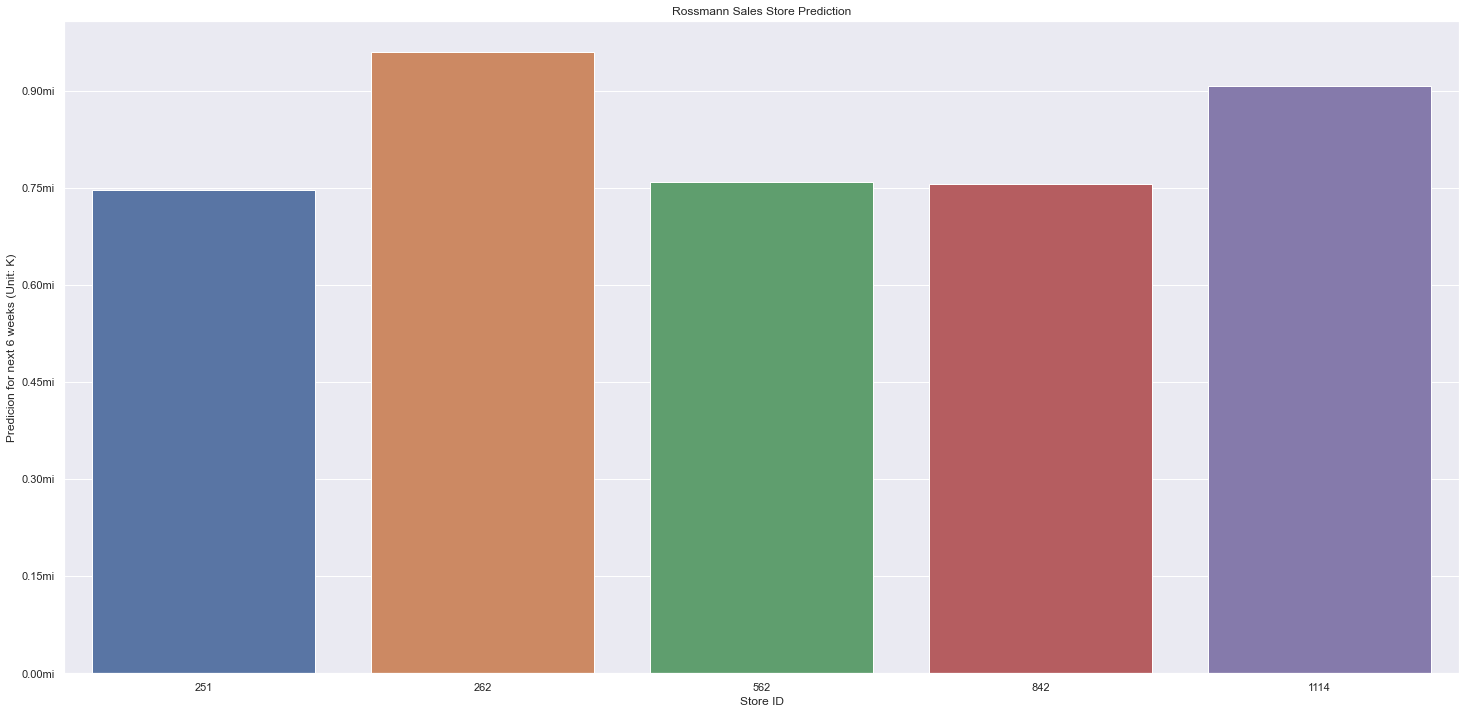

In [29]:
df_pred = d2.nlargest(5, 'prediction')
get_graph(
    df_pred,
    x_axis='store',
    y_axis='prediction',
    title='Rossmann Sales Store Prediction',
    y_label='Predicion for next 6 weeks (Unit: K)',
    x_label='Store ID',
    img_name='top5_prediction.png',
    divisor=1000000,
    tick_format='{:,.2f}mi'
)

In [37]:
df_pred.head()

,store,prediction
854,1114,775322.559570
433,562,720852.629883
201,262,650218.425781
646,842,516724.011719
359,467,502788.233398


- Menu com todas as lojas disponíveis
    - lista: código - <font color='red'>refutada</font>
- Top 5 maiores faturamentos totais
     - gráfico de barras - <font color='blue'>DONE!</font>
- Top 5 maiores previsões
     - gráfico de barras - <font color='blue'>DONE!</font>
- All
     - lista: código, previsão, venda total - <font color='red'>refutada</font>
- Filtro para uma única loja ou uma lista de lojas
     - mensagem: Store Number n will sell v in the next 6 weeks - <font color='blue'>DONE!</font>

In [37]:
file_sales = '/home/bem/repos/rossmann_sales_predict/rossmann_sales_predict/data/raw/train.csv'
df_sales = pd.read_csv(file_sales)
df_sales.columns = [col.lower() for col in df_sales.columns]

init_date = '2014-08-01'
df_sales = df_sales.loc[df_sales['date'] >= init_date]

store_predicted = d2['store'].unique()

d3 = df_sales.loc[df_sales['store'].isin(store_predicted), ['store', 'sales']].groupby('store').sum().reset_index()

d4 = pd.merge(d2, d3, on='store', how='left')
d4['total'] = d4['prediction'] + d4['sales']

df_pred = d4[['store', 'total']].sort_values(by='total', ascending=False).head(5)

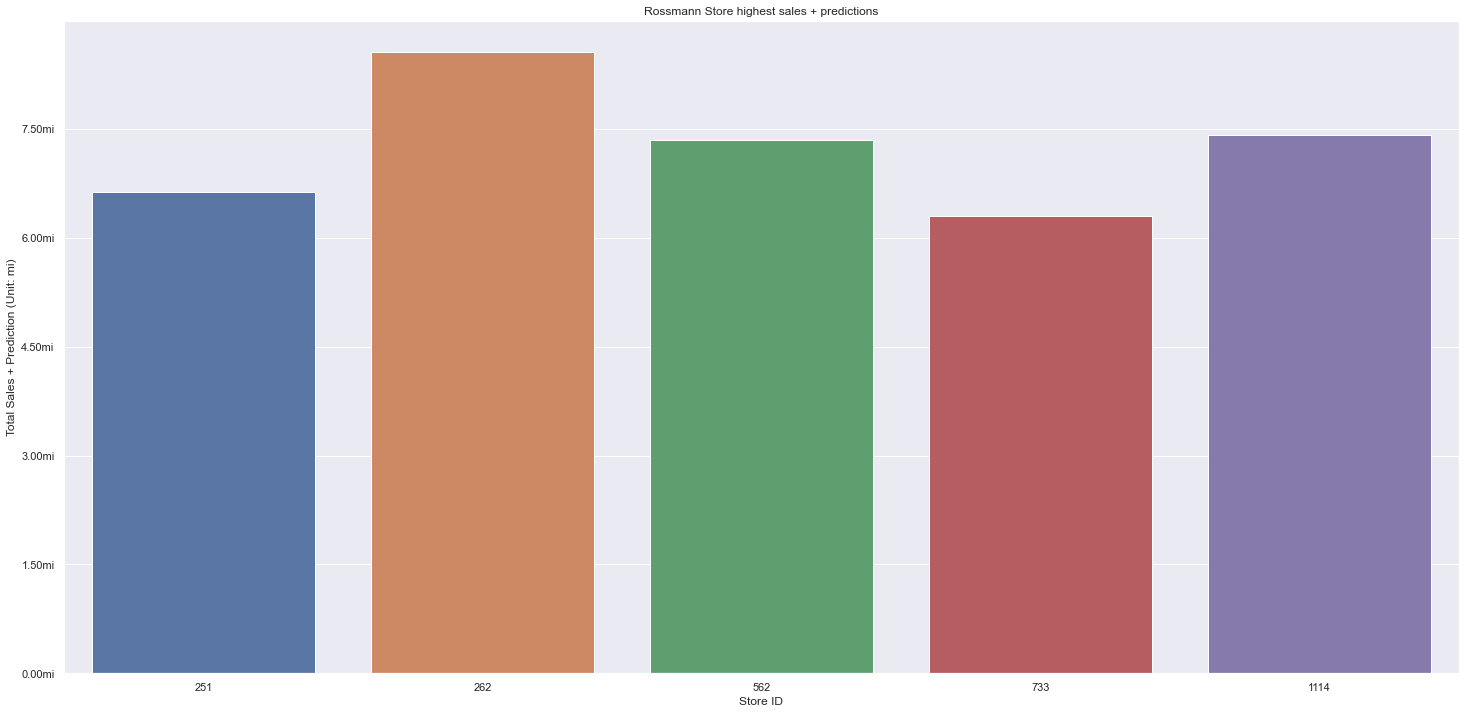

In [38]:
# Top 5 maiores previsões

# fig = sns.barplot(x='store', y='total', data=df_top5)
# fig.set_title('Top 5 Rossmann Sales Store')
# fig.set_ylabel('Total Sales + Prediction (Unit: K)')
# fig.set_xlabel('Store ID')
# ylabels = ['{:,.0f}'.format(x) + 'K' for x in fig.get_yticks()/1000]
# fig.set_yticklabels(ylabels);

# get_graph(
#     df_pred,
#     x_axis='store',
#     y_axis='total',
#     title='Rossmann Store highest sales + predictions',
#     ylabel='Total Sales + Prediction (Unit: K)',
#     xlabel='Store ID',
#     img_name='top5_sales.png'
# )

get_graph(
    df_pred,
    x_axis='store',
    y_axis='total',
    title='Rossmann Store highest sales + predictions',
    y_label='Total Sales + Prediction (Unit: mi)',
    x_label='Store ID',
    img_name='./top5_sales.png',
    divisor=1000000,
    tick_format='{:,.2f}mi'
)

In [91]:
d3.head()

,store,prediction
854,1114,775322.559570
433,562,720852.629883
201,262,650218.425781
646,842,516724.011719
359,467,502788.233398


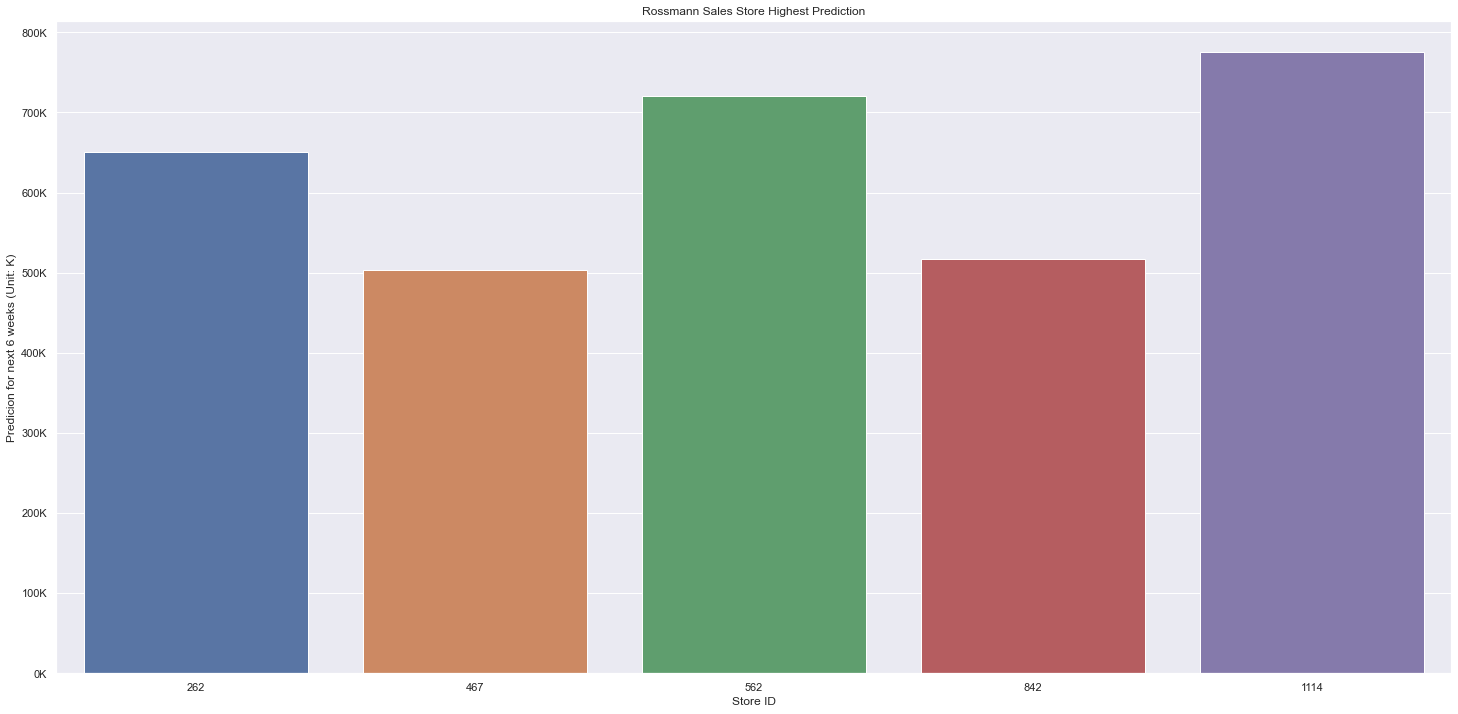

In [14]:
d3 = d2.nlargest(5, 'prediction')

# graph definitions
x_ax = 'store'
y_ax = 'prediction'
graph_title = 'Rossmann Sales Store Highest Prediction'
x_lbl = 'Store ID'
y_lbl = 'Predicion for next 6 weeks (Unit: K)'
image_name = 'top5_prediction.png'

# get_graph(
#     d3,
#     x_axis='store',
#     y_axis='prediction',
#     title='Rossmann Sales Store Prediction',
#     ylabel='Predicion for next 6 weeks (Unit: K)',
#     xlabel='Store ID',
#     img_name='top5_prediction.png'
# )

get_graph(
    d3,
    x_axis=x_ax,
    y_axis=y_ax,
    title=graph_title,
    xlabel=x_lbl,
    ylabel=y_lbl,
    img_name=image_name
)


In [32]:
a = open('top5_prediction.png', 'rb')

In [33]:
a

<_io.BufferedReader name='top5_prediction.png'>